In [1]:
from scipy.constants import h, k as k_B
from physics.mkid import model

In [90]:
# The critical temperature, in K.
T_c = 1.4

# The active volume, in um^3.
active_volume_um3 = 2000 * 8 * 0.1  # 1600 um^3, significantly higher than current design.

# The substrate temperature, in K.
T_substrate = 0.1

# Controls the effective quasiparticle recombination time.
phonon_trapping_factor = 2

# The kinetic inductance fraction; this is an approximate value from some Sonnet sims
alpha = 0.20

# The resonance frequency, in Hz.
f_r = 3e9

# The inverse coupling quality factor.
iQc = 50e-6

# The limiting inverse internal quality factor; this value is negligible here.
iQi0 = 1e-6

# The TLS fractional frequency spectral density, in 1 / Hz, at critical power P_c and some fiducial frequency.
S_TLS_at_P_c = 1e-18  

# The TLS critical power, in W, above which S_TLS \propto P_i^{-1/2}.
P_c = 1e-15

# The amplifier noise temperature, in K.
T_amp = 8

# The ratio of absorbed readout power to absorbed optical power.
internal_over_optical = 10

# Optical bandwidth, in Hz
bandwidth = (170 - 130) * 1e9

# Broadband center frequency, in Hz
nu_center = 150e9

In [91]:
print("Active volume = {:.0f} um^3".format(active_volume_um3))

kid = model.KID(active_metal=model.Aluminum(T_c=T_c),
                active_volume_um3=active_volume_um3,
                inactive_metal=None,  # Not used.
                inactive_volume_um3=0,  # Not used.
                substrate=model.Substrate(T=T_substrate),
                phonon_trapping_factor=phonon_trapping_factor,
                alpha=alpha,
                f_r=f_r,
                iQc=iQc,
                iQi0=iQi0,
                S_TLS_at_P_c=S_TLS_at_P_c,
                P_c=P_c)

Active volume = 1600 um^3


In [92]:
# The target optical power
P_A_target = 1e-12

# Optical system and environment


# Absorbed power, in W.
P_A = np.logspace(-14, -10, 1e4)

# Quasiparticle generation rate, in quasiparticles per s.
Gamma_A = kid.optical_generation_rate(P_A, nu_center)

# Total generation rate
Gamma = Gamma_A + kid.thermal_generation_rate()

# Readout parameters

# Readout power, in W.
P_g = internal_over_optical * P_A / kid.chi_a(kid.iQi(Gamma))

# Derived constants
print("\\Delta = {:.0f} ueV".format(1e6 * kid.active_metal.Delta_eV))

# Gap frequency
print("\\nu_g = {:.1f} GHz".format(1e-9 * kid.active_metal.nu_gap))

# Recombination constant
print("R = {:.1f} um^3 s^-1".format(kid.active_metal.R_um3_per_s))

# Effective recombination constant
print("R_* = {:.1f} um^3 s^-1".format(kid.effective_recombination_um3_per_s))

# Number of quasiparticles per photon at center frequency
print("m_center = {:.2f}".format(kid.active_metal.quasiparticles_per_photon(nu_center)))

# Optical generation rate
print("{:.2g} s^-1 <= Gamma_A <= {:.2g} s^-1".format(Gamma_A[0], Gamma_A[-1]))

# Thermal generation rate
print("Gamma_t = {:.2g} s^-1".format(kid.thermal_generation_rate()))

\Delta = 213 ueV
\nu_g = 102.9 GHz
R = 6.8 um^3 s^-1
R_* = 3.4 um^3 s^-1
m_center = 2.00
2e+08 s^-1 <= Gamma_A <= 2e+12 s^-1
Gamma_t = 5.3e-05 s^-1


In [93]:
#
Gamma_target = Gamma[np.argmin(np.abs(P_A_target - P_A))]
Q_target = 1 / (kid.iQi(Gamma=Gamma_target) + kid.iQc)
print("Coupling quality factor is {:.5g}".format(1 / kid.iQc))
print("Internal quality factor at target power of {:.1f} pW is {:.5g}".format(1e12 * P_A_target, 1 / kid.iQi(Gamma=Gamma_target)))
print("Loaded quality factor at target power of {:.1f} pW is {:.5g}".format(1e12 * P_A_target, Q_target))

Coupling quality factor is 20000
Internal quality factor at target power of 1.0 pW is 14863
Loaded quality factor at target power of 1.0 pW is 8526.4


# NEP

In [94]:
# Plot parameters
P_A_scale = 1e12

photon_color = 'red'
recombination_color = 'blue'
amp_color = 'green'
TLS_color = 'brown'
nonamp_color = amp_color
nonphoton_color = photon_color
total_color = 'black'
P_A_target_color = 'gray'

iQ_color = 'red'
x_color = 'blue'
iQi_color = 'brown'
iQc_color = 'black'
tau_qp_color = 'green'

In [95]:
# NEP^2 contributions
photon = kid.NEP2_photon(Gamma=Gamma_A, nu=nu_center, bandwidth=bandwidth)
recombination = kid.NEP2_recombination(Gamma=Gamma, nu=nu_center)
amplifier = kid.NEP2_amp(T_amp=T_amp, P_g=P_g, Gamma=Gamma, nu=nu_center)
TLS = kid.NEP2_TLS(P_g=P_g, Gamma=Gamma, nu=nu_center)
nonamp = photon + recombination + TLS
nonphoton = recombination + amplifier + TLS
total = photon + recombination + amplifier + TLS

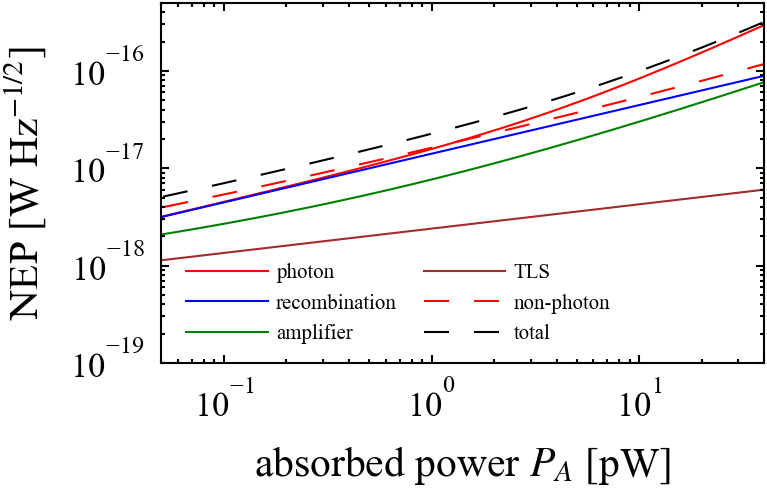

In [97]:
plt.rcParams['legend.handlelength'] = 4.5
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('NEP [W Hz$^{-1/2}$]')

#ax.axvline(P_A_scale * P_A_target, linestyle='-', color=P_A_target_color)

ax.plot(P_A_scale * P_A,
        photon**(1/2),
        linestyle='-',
        color=photon_color, label='photon')

ax.plot(P_A_scale * P_A,
        recombination**(1/2),
        linestyle='-',
        color=recombination_color, label='recombination')

ax.plot(P_A_scale * P_A,
        amplifier**(1/2),
        linestyle='-',
        color=amp_color, label='amplifier')

ax.plot(P_A_scale * P_A,
        TLS**(1/2),
        linestyle='-',
        color=TLS_color, label='TLS')

"""
ax.plot(P_A_scale * P_A,
        nonamp**(1/2),
        linestyle='--',
        color=nonamp_color, label='non-amplifier')
"""
ax.plot(P_A_scale * P_A,
        nonphoton**(1/2),
        linestyle='--',
        color=nonphoton_color, label='non-photon')

ax.plot(P_A_scale * P_A,
        total**(1/2),
        linestyle='--',
        color=total_color, label='total')

ax.set_xlim(5e-2, 4e1)
ax.set_ylim(1e-19, 5e-16)
ax.legend(loc='lower left', fontsize=5, ncol=2)

fig.savefig('/Users/daniel/NEP_vs_PA_2016-06-26.pdf')

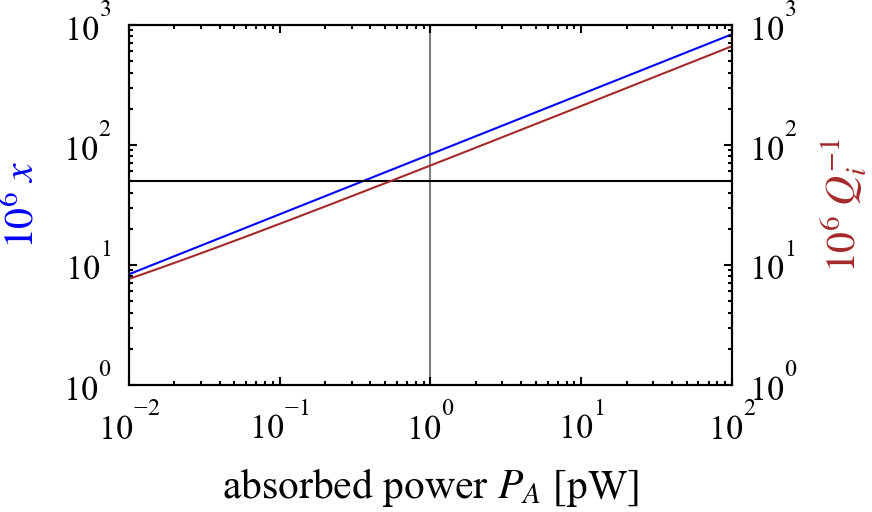

In [98]:
fig, x_ax = plt.subplots()
iQi_ax = x_ax.twinx()

x_ax.set_xscale('log')
x_ax.set_yscale('log')
iQi_ax.set_yscale('log')
x_ax.set_xlabel('absorbed power $P_A$ [pW]')
x_ax.set_ylabel('$10^6 \; x$', color=x_color)
iQi_ax.set_ylabel('$10^6 \; Q_i^{-1}$', color=iQi_color)

iQi_ax.axhline(1e6 * kid.iQc, color=iQc_color)

x_ax.axvline(P_A_scale * P_A_target, linestyle='-', color=P_A_target_color)

x_ax.plot(P_A_scale * P_A,
            1e6 * (kid.x(Gamma=Gamma) - kid.x(Gamma=kid.thermal_generation_rate())),
            color=x_color)

iQi_ax.plot(P_A_scale * P_A,
            1e6 * kid.iQi(Gamma=Gamma),
            color=iQi_color)

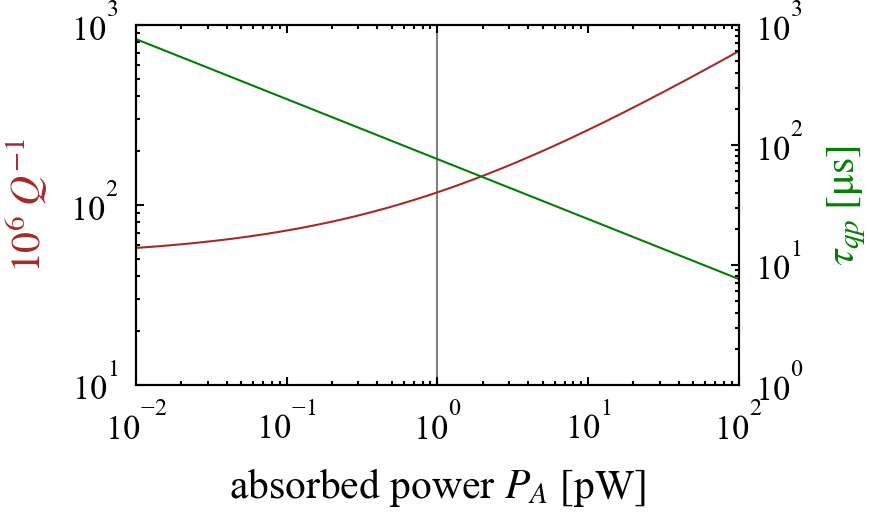

In [99]:
fig, iQ_ax = plt.subplots()
tau_qp_ax = iQ_ax.twinx()

iQ_ax.set_xscale('log')
iQ_ax.set_yscale('log')
tau_qp_ax.set_yscale('log')
iQ_ax.set_xlabel('absorbed power $P_A$ [pW]')
iQ_ax.set_ylabel('$10^6 \; Q^{-1}$', color=iQi_color)
tau_qp_ax.set_ylabel(r'$\tau_{qp} \; [\mathrm{\mu s}]$', color=tau_qp_color)

iQ_ax.axvline(P_A_scale * P_A_target, linestyle='-', color=P_A_target_color)

iQ_ax.plot(P_A_scale * P_A,
            1e6 * (kid.iQi(Gamma=Gamma) + kid.iQc),
            color=iQi_color)

tau_qp_ax.plot(P_A_scale * P_A,
               1e6 * kid.tau_qp(Gamma=Gamma),
               color=tau_qp_color)


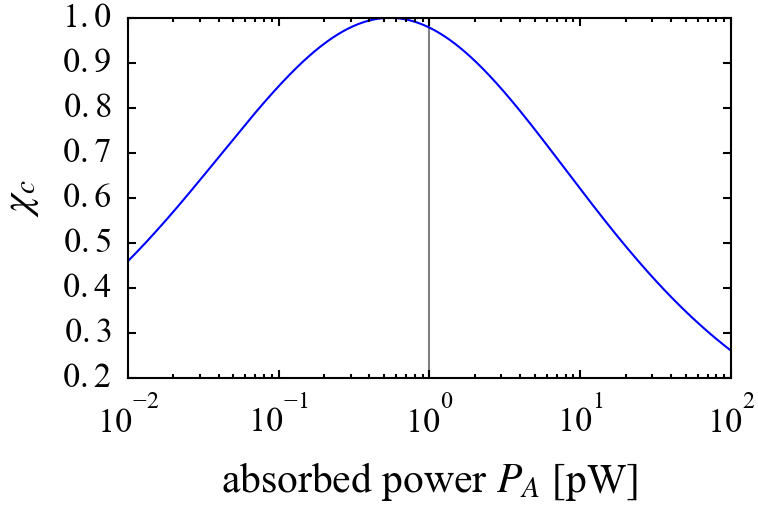

In [100]:
fig, ax = plt.subplots()
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel(r'$\chi_c$')

ax.axvline(P_A_scale * P_A_target, linestyle='-', color=P_A_target_color)

ax.semilogx(P_A_scale * P_A,
            kid.chi_c(kid.iQi(Gamma)))

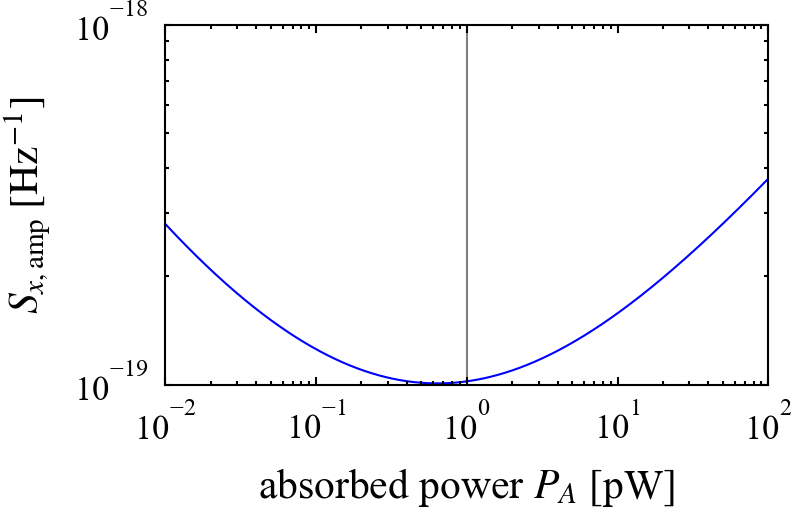

In [101]:
fig, ax = plt.subplots()
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel(r'$S_{x, \mathrm{amp}} \; [\mathrm{Hz}^{-1}]$')

ax.axvline(P_A_scale * P_A_target, linestyle='-', color=P_A_target_color)

ax.loglog(P_A_scale * P_A,
          (k_B * T_amp / P_g) / np.abs(kid.d_S21_d_x(kid.iQi(Gamma=Gamma)))**2)

# Generation efficiency

In [102]:
nu = np.linspace(0, 4 * kid.active_metal.nu_gap, 1e3)
nu = nu[1:]

In [103]:
eta_color = 'blue'
m_color = 'green'

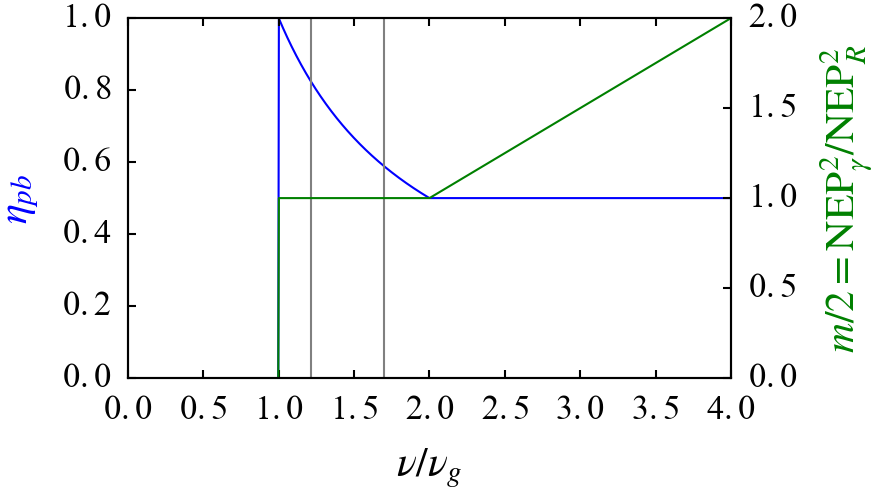

In [104]:
fig, eta_ax = plt.subplots()
m_ax = eta_ax.twinx()

eta_ax.plot(nu / kid.active_metal.nu_gap,
            [kid.active_metal.eta_pb(n) for n in nu],
            color=eta_color)
eta_ax.set_xlabel(r'$\nu / \nu_g$')
eta_ax.set_ylabel(r'$\eta_{pb}$', color=eta_color)
m_ax.plot(nu / kid.active_metal.nu_gap,
          [kid.active_metal.quasiparticles_per_photon(n) / 2 for n in nu],
          color=m_color)
m_ax.set_ylabel('$m / 2 = \mathrm{NEP}_\gamma^2 / \mathrm{NEP}_R^2$',
                color=m_color)

eta_ax.axvline(125e9 / kid.active_metal.nu_gap, color='gray')
eta_ax.axvline(175e9 / kid.active_metal.nu_gap, color='gray')